# Zanim puścimy komórki kodu poniżej 

Tutaj znajduje się skrypt SLURM, jakiego ja używam aby włączyć sobie sesję Jupyter lokalnie na Atenie:

```
#!/bin/bash
#SBATCH --partition plgrid-gpu-a100
#SBATCH --nodes 1
#SBATCH --ntasks-per-node 96
#SBATCH --gres=gpu:1
#SBATCH --time 15:30:00
#SBATCH --job-name jupyter-notebook-tunnel
#SBATCH --output jupyter-log-%J.txt
#SBATCH --chdir="/net/tscratch/people/plgdusza/Sussex Dataset"

## get tunneling info
XDG_RUNTIME_DIR=""
ipnport=$(shuf -i8000-9999 -n1)
ipnip=$(hostname -i)
user=$USER

cd "/net/tscratch/people/plgdusza/Sussex Dataset" || { 
    echo "ERROR: Could not cd to scratch at /net/tscratch/people/plgdusza/Sussex Dataset" >&2
    exit 1
}

module load GCCcore/13.2.0 Python/3.11.5
python3.11 -m venv venv                            # create venv under scratch
source venv/bin/activate                           # activate venv

pip install --upgrade pip                          # update pip in venv 
pip install jupyterlab ipykernel torch==2.2.2+cu121 \
  torchvision==0.17.2+cu121 torchaudio==2.2.2+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
#pip install jupyterlab ipykernel torch==2.0.1+cu117 \
#    torchvision==0.15.2+cu117 torchaudio==2.0.2


module load GCC/11.3.0
module load NVHPC/22.11-CUDA-11.7.0
module load OpenMPI/4.1.4
module load TensorFlow/2.11.0-CUDA-11.7.0
module load JupyterLab/3.5.0



## print tunneling instructions to jupyter-log-{jobid}.txt
echo -e "
    Copy/Paste this in your local terminal to ssh tunnel with remote
    -----------------------------------------------------------------
    ssh -o ServerAliveInterval=300 -N -L $ipnport:$ipnip:$ipnport ${user}@athena.cyfronet.pl
    -----------------------------------------------------------------
 
    Then open a browser on your local machine to the following address
    ------------------------------------------------------------------
    localhost:$ipnport  (prefix w/ https:// if using password)
    ------------------------------------------------------------------
    "
## start an ipcluster instance and launch jupyter server
jupyter lab --no-browser --port=$ipnport --ip=$ipnip


echo "=== Deactivating and removing virtual environment ==="
deactivate
```

Skrypt ten będzie tworzyć plik txt z kodem ssh do Ateny, oraz późniejszym linkiem http do Colaba u mnie na scratchu w folderze Sussex, w celu zmiany lokalizacji pojawienia się pliku txt, trzeba zmienić tą linijkę kodu ze swoją ścieżką:

```
cd "/net/tscratch/people/plgdusza/Sussex Dataset" || { 
    echo "ERROR: Could not cd to scratch at /net/tscratch/people/plgdusza/Sussex Dataset" >&2
    exit 1
}
```

Ale ponieważ rozumiem macie dostęp do mojego scratcha, nie jest to potrzebne, tylko wiedzcie żeby szukać txt w **/net/tscratch/people/plgdusza/Sussex Dataset**

**UWAGA, skrypt SLURM powyżej jest na 15h**, należy to dostosować do czasu jaki mniej więcej kod poniżej uczenia modeli się będzie wykonywać aby nie stracić modelu i żeby nie marnować resourców

# Sprawdzanie importów na venvie

In [ ]:
import os
import pkg_resources

def calc_container(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size


dists = list(pkg_resources.working_set)
total_size=0
for dist in dists:
    try:
        path = os.path.join(dist.location, dist.project_name)
        size = calc_container(path)
        # Convert to megabytes and print with two decimal places
        size_mb = size / 1_000_000
        total_size+=size_mb
        if size_mb > 0.001:
            print(f"{dist}: {size_mb:.2f} MB")
            print("-" * 40)
    except OSError:
        print(f"{dist.project_name} no longer exists")

print("total size = ", total_size)


jupyterlab 3.5.0: 17.81 MB
----------------------------------------
json5 0.9.10: 0.13 MB
----------------------------------------
nbclassic 0.4.8: 36.04 MB
----------------------------------------
anyio 3.6.1: 0.58 MB
----------------------------------------
sniffio 1.3.0: 0.01 MB
----------------------------------------
ipywidgets 7.6.3: 0.60 MB
----------------------------------------
ipykernel 6.13.0: 0.70 MB
----------------------------------------
nbconvert 6.5.3: 1.46 MB
----------------------------------------
notebook 6.4.0: 34.68 MB
----------------------------------------
tornado 6.2: 2.91 MB
----------------------------------------
nbformat 5.4.0: 0.39 MB
----------------------------------------
traitlets 5.2.0: 0.82 MB
----------------------------------------
bleach 5.0.1: 1.15 MB
----------------------------------------
widgetsnbextension 3.5.1: 4.61 MB
----------------------------------------
fastjsonschema 2.16.1: 0.14 MB
----------------------------------------
asttoke

# Jeśli macie dostęp do mojego scratcha to **nie róbcie** tego tutaj w tej sekcji

Jak macie dane idziemy dalej, ponieważ te tutaj kody zajmują 30 minut, one już zostały spreparowane

In [ ]:
#Creating a Big Dataset

In [ ]:
import os, glob
import numpy as np

# —————————————————————
# 1. CONFIG
# —————————————————————
BASE_4LOC   = '/net/tscratch/people/plgdusza/Sussex Dataset'
BASE_FUSION = '/net/tscratch/people/plgdusza/Sussex Dataset/sensor_fusion'
splits      = ['train', 'validation']
subdirs     = ['Bag', 'Hand', 'Hips', 'Torso']
TIMESTEPS   = 500

X_list, y_list = [], []

# —————————————————————
# 2. LOOP OVER SPLITS & LOCATIONS
# —————————————————————
for split in splits:
    for loc in subdirs:
        # paths
        path_4loc   = os.path.join(BASE_4LOC,   split, loc)
        path_fusion = os.path.join(BASE_FUSION, split, loc)

        # 2a) Read Label.txt once
        lbl1 = os.path.join(path_4loc,   'Label.txt')
        lbl2 = os.path.join(path_fusion, 'Label.txt')
        label_fp = lbl1 if os.path.exists(lbl1) else lbl2
        if not os.path.exists(label_fp):
            raise FileNotFoundError(f"No Label.txt in {path_4loc} or {path_fusion}")

        # load label lines
        with open(label_fp, 'r') as f:
            lbl_lines = f.read().splitlines()

        # compute per-row mode (most frequent value)
        modes = []
        for line in lbl_lines:
            if not line.strip():
                # blank line → treat as NaN label
                modes.append(np.nan)
            else:
                vals = [int(x) for x in line.split()]
                modes.append(int(np.bincount(vals).argmax()))
        modes     = np.array(modes)            # shape: (n_windows,)
        n_windows = len(modes)
        print(f"\n[{split}/{loc}] labels rows = {n_windows}")

        # 2b) Gather sensor files (exclude the Label.txt itself)
        files_9  = sorted(glob.glob(os.path.join(path_4loc,   '*.txt')))
        files_4  = sorted(glob.glob(os.path.join(path_fusion, '*.txt')))
        all_txt  = files_9 + files_4
        sensor_files = [fp for fp in all_txt
                        if os.path.basename(fp).lower() != 'label.txt']

        if len(sensor_files) != 13:
            print(f"Warning: expected 13 sensor files, found {len(sensor_files)}")

        # 2c) Read each sensor file manually
        sensor_arrays = []
        for fp in sensor_files:
            # read raw lines
            with open(fp, 'r') as f:
                lines = f.read().splitlines()

            # parse each line into a float array (or NaNs if blank)
            arr_rows = []
            for line in lines:
                if not line.strip():
                    arr_rows.append(np.full((TIMESTEPS,), np.nan))
                else:
                    row = np.fromstring(line, dtype=float, sep=' ')
                    arr_rows.append(row)
            arr = np.vstack(arr_rows)  # shape: (n_rows_in_file, TIMESTEPS)
            print(f"  Read {os.path.basename(fp)} → {arr.shape}")

            # pad or truncate at the end to match n_windows
            n_rows = arr.shape[0]
            if n_rows < n_windows:
                pad = np.full((n_windows - n_rows, TIMESTEPS), np.nan)
                arr = np.vstack([arr, pad])
                print(f"    → Padded {n_windows-n_rows} rows of NaN")
            elif n_rows > n_windows:
                arr = arr[:n_windows, :]
                print(f"    → Truncated to {n_windows} rows")

            sensor_arrays.append(arr)

        # 3) Stack channels → (n_windows, TIMESTEPS, 13)
        X_loc = np.stack(sensor_arrays, axis=2)
        y_loc = modes - 1   # zero-based labels if you need

        print(f"  Stacked shape: {X_loc.shape}")
        X_list.append(X_loc)
        y_list.append(y_loc)

# —————————————————————
# 4. FINAL CONCAT
# —————————————————————
X_all = np.concatenate(X_list, axis=0)  # → (total_windows, 500, 13)
y_all = np.concatenate(y_list, axis=0)  # → (total_windows,)

print(f"\nFinal X_all shape: {X_all.shape}")
print(f"Final y_all shape: {y_all.shape}")



[train/Bag] labels rows = 196072
  Read Acc_x.txt → (196072, 500)
  Read Acc_y.txt → (196072, 500)
  Read Acc_z.txt → (196072, 500)
  Read Gyr_x.txt → (196072, 500)
  Read Gyr_y.txt → (196072, 500)
  Read Gyr_z.txt → (196072, 500)
  Read Mag_x.txt → (196072, 500)
  Read Mag_y.txt → (196072, 500)
  Read Mag_z.txt → (196072, 500)
  Read Acc_rot_x.txt → (196072, 500)
  Read Acc_rot_y.txt → (196072, 500)
  Read Acc_rot_z.txt → (196072, 500)
  Read Acc_solo_mag.txt → (196072, 500)
  Stacked shape: (196072, 500, 13)

[train/Hand] labels rows = 196072
  Read Acc_x.txt → (196072, 500)
  Read Acc_y.txt → (196072, 500)
  Read Acc_z.txt → (196072, 500)
  Read Gyr_x.txt → (196072, 500)
  Read Gyr_y.txt → (196072, 500)
  Read Gyr_z.txt → (196072, 500)
  Read Mag_x.txt → (196072, 500)
  Read Mag_y.txt → (196072, 500)
  Read Mag_z.txt → (196072, 500)
  Read Acc_rot_x.txt → (196072, 500)
  Read Acc_rot_y.txt → (196072, 500)
  Read Acc_rot_z.txt → (196072, 500)
  Read Acc_solo_mag.txt → (196072, 500)


In [ ]:
out_path = '/net/tscratch/people/plgdusza/Sussex Dataset/NPZ files data/X_y_data.npz'

# this will bundle both X_all and y_all into one compressed archive
np.savez(out_path, X_all=X_all, y_all=y_all)
print(f"Saved X_all and y_all to {out_path}")

# TUTAJ START instalacja wszystkich bibliotek oraz import danych
Musicie się upewnić, że nie macie nic na swoim koncie prywatnym na /net/people/plgrid/plg[username] bo inaczej zabraknie wam miejsca.

Ilość miejsca zajętego możecie sprawdzić poprzez puszczenie w terminalu na Atenie poprzez ssh plg *username* @athena.cyfronet.pl:

```
hpc-fs
```
powinniście zobaczyć coś takiego, gdzie interesuje was ścieżka $HOME, i powinna być prawie pusta, ponieważ instalacja wszystkich bibliotek tutaj potrzebnych zajmuje ponad 7GB.
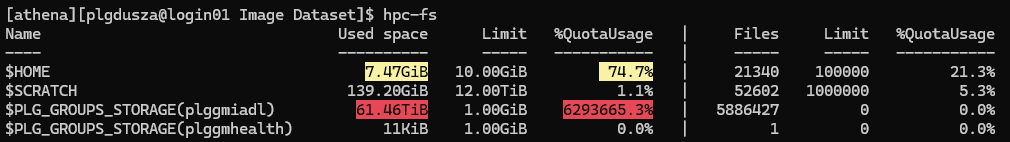

In [ ]:
#Start Here - Loading data from saved dataset and spliting

In [ ]:
!pip install --q scikit-learn matplotlib seaborn pypots "numpy<2"

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install --upgrade --q \
  torch==2.2.2+cu121 \
  torchvision==0.17.2+cu121 \
  torchaudio==2.2.2+cu121 \
  --index-url https://download.pytorch.org/whl/cu121


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 14.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 17.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 17.8 MB/s eta 0:00:0

Import zbioru danych poniżej, ze scratcha plgdusza

Output MUSI wyglądać w ten sposób, a komórka wykona się w ok. 2/3 minuty:

```
All the files were read
Converted to tensor
Combined full tensor dataset
Simple split compute
Split achieved
After random_split:
  len(train_ds): 629610
  len(val_ds):   134916
  len(test_ds):  134918
One training batch shapes:
  xb (inputs)  : torch.Size([32, 500, 13])   # (batch_size, n_steps, n_features)
  yb (targets) : torch.Size([32])   # (batch_size,)
  ```

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split


data = np.load('/net/tscratch/people/plgdusza/Sussex Dataset/NPZ files data/X_y_data.npz')
X_all = data['X_all']
y_all = data['y_all']

print("All the files were read")


# Convert once to tensors
X_tensor = torch.from_numpy(X_all).float()
y_tensor = torch.from_numpy(y_all).long()
X_tensor = X_tensor.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
y_tensor = y_tensor.nan_to_num(nan=0, posinf=0, neginf=0)
print("Converted to tensor")

full_ds = TensorDataset(X_tensor, y_tensor)
print("Combined full tensor dataset")


# Compute split sizes
n = len(full_ds)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)
n_test  = n - n_train - n_val
print("Simple split compute")

# This only builds index lists, no data copy
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

print("Split achieved")
print("After random_split:")
print(f"  len(train_ds): {len(train_ds)}")
print(f"  len(val_ds):   {len(val_ds)}")
print(f"  len(test_ds):  {len(test_ds)}")

from torch.utils.data import DataLoader
loader = DataLoader(train_ds, batch_size=32, shuffle=True)
xb, yb = next(iter(loader))
print("One training batch shapes:")
print(f"  xb (inputs)  : {xb.shape}   # (batch_size, n_steps, n_features)")
print(f"  yb (targets) : {yb.shape}   # (batch_size,)")


All the files were read
Converted to tensor
Combined full tensor dataset
Simple split compute
Split achieved
After random_split:
  len(train_ds): 629610
  len(val_ds):   134916
  len(test_ds):  134918
One training batch shapes:
  xb (inputs)  : torch.Size([32, 500, 13])   # (batch_size, n_steps, n_features)
  yb (targets) : torch.Size([32])   # (batch_size,)


# Początek Treningu
Przykładowy TimesNet

Czas na epokę: ok. 10 min

In [ ]:
# === Imports ===
import os, glob
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# PyPOTS TimesNet import
from pypots.classification.timesnet.model import TimesNet


# === DataLoaders ===
batch_size = 1024

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

# === Model, Optimizer, and Loss ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

n_steps, n_features = X_tensor.shape[1], X_tensor.shape[2]
n_classes = int(torch.unique(y_tensor).numel())

model = TimesNet(
    n_steps=n_steps,
    n_features=n_features,
    n_classes=n_classes,
    n_layers=3,
    top_k=3,
    d_model=64,
    d_ffn=128,
    n_kernels=4,
    device=device
)


optimizer = Adam(model.model.parameters(), lr=1e-4)
criterion = CrossEntropyLoss()

# === Training Loop (with NaN-guards + batch-skip) ===
epochs = 5
for epoch in range(1, epochs + 1):
    model.model.train()
    total_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = len(train_loader)
    print(f"\nEpoch {epoch}/{epochs} — {num_batches} batches")

    for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
        xb, yb = xb.to(device), yb.to(device)

        # guard again per-batch just in case
        xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

        outputs = model.model({"X": xb})
        logits = outputs.get("logits")
        if logits is None:
            raise RuntimeError("Expected 'logits' in TimesNet output for proper loss computation.")

        # wipe any NaNs/Infs in logits
        logits = logits.nan_to_num(nan=0.0, posinf=1e3, neginf=-1e3)

        loss = criterion(logits, yb)
        if torch.isnan(loss):
            print(f"\nWarning: loss=NaN at batch {batch_idx}, skipping this batch")
            continue

        # per-batch accuracy
        preds = logits.argmax(dim=1)
        correct = (preds == yb).sum().item()
        batch_acc = correct / yb.size(0)

        epoch_correct += correct
        epoch_total += yb.size(0)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        print(f"  Batch {batch_idx}/{num_batches} — loss: {loss.item():.4f} — acc: {batch_acc*100:.2f}%", end='\r')

    avg_loss = total_loss / num_batches
    avg_acc = epoch_correct / epoch_total if epoch_total>0 else 0
    print(f"\nEpoch {epoch} completed — avg train loss: {avg_loss:.4f} — avg train acc: {avg_acc*100:.2f}%")

# === Evaluation on Test Set ===
model.model.eval()
all_preds, all_labels = [], []
num_test_batches = len(test_loader)
print(f"\nEvaluating on test set — {num_test_batches} batches")

with torch.no_grad():
    for batch_idx, (xb, yb) in enumerate(test_loader, start=1):
        xb = xb.to(device)
        xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
        outputs = model.model({"X": xb})
        probs = outputs["classification_proba"].nan_to_num(nan=1e-9, posinf=1.0, neginf=0.0)
        preds = probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        print(f"  Test batch {batch_idx}/{num_test_batches}", end='\r')

print("\n\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, digits=4))

2025-06-20 14:21:34 [INFO]: Using the given device: cuda
2025-06-20 14:21:34 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-06-20 14:21:34 [INFO]: Using customized CrossEntropy as the training loss function.
2025-06-20 14:21:34 [INFO]: Using customized CrossEntropy as the validation metric function.
2025-06-20 14:21:34 [INFO]: TimesNet initialized with the given hyperparameters, the number of trainable parameters: 4,389,832


Using device: cuda

Epoch 1/5 — 615 batches
  Batch 615/615 — loss: 1.2209 — acc: 53.09%
Epoch 1 completed — avg train loss: 1.3994 — avg train acc: 45.70%

Epoch 2/5 — 615 batches
  Batch 615/615 — loss: 1.1236 — acc: 60.53%
Epoch 2 completed — avg train loss: 1.1868 — avg train acc: 55.45%

Epoch 3/5 — 615 batches
  Batch 615/615 — loss: 1.1297 — acc: 59.38%
Epoch 3 completed — avg train loss: 1.1343 — avg train acc: 57.68%

Epoch 4/5 — 615 batches
  Batch 615/615 — loss: 1.0968 — acc: 60.30%
Epoch 4 completed — avg train loss: 1.1010 — avg train acc: 58.96%

Epoch 5/5 — 615 batches
  Batch 615/615 — loss: 1.1281 — acc: 62.01%
Epoch 5 completed — avg train loss: 1.0721 — avg train acc: 60.15%

Evaluating on test set — 132 batches
  Test batch 132/132

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.5698    0.6552    0.6096     18094
           1     0.7330    0.8139    0.7713     17838
           2     0.8738    0.9022    0.8878

# **Dodane wag na klasę** (w zależności od F1 per klasa uzyskane powyżej) oraz zwiększenie epok

In [ ]:
import os, glob
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# PyPOTS TimesNet import
from pypots.classification.timesnet.model import TimesNet


# === DataLoaders ===
batch_size = 1024

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

# === Compute class-weights from F1-scores ===
# F1-scores from last report, in class order 0..7
f1_scores = np.array([0.6096, 0.7713, 0.8878, 0.7287, 0.6748, 0.4586, 0.4914, 0.3485], dtype=np.float32)
# Inverse-F1 weighting: lower-F1 classes get higher weight
inv_f1 = 1.0 / (f1_scores + 1e-6)  # avoid division by zero

# === Model, Optimizer, and Loss ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# class_weights on the correct device
class_weights = torch.tensor(inv_f1, device=device)

n_steps, n_features = X_tensor.shape[1], X_tensor.shape[2]
n_classes = int(torch.unique(y_tensor).numel())

model = TimesNet(
    n_steps=n_steps,
    n_features=n_features,
    n_classes=n_classes,
    n_layers=3,
    top_k=3,
    d_model=64,
    d_ffn=128,
    n_kernels=4,
    device=device
)

# drop lr to 1e-4 to stabilize
optimizer = Adam(model.model.parameters(), lr=1e-4)
# pass class_weights into the loss
criterion = CrossEntropyLoss(weight=class_weights)

# === Training Loop (with NaN-guards + batch-skip) ===
epochs = 15
for epoch in range(1, epochs + 1):
    model.model.train()
    total_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = len(train_loader)
    print(f"\nEpoch {epoch}/{epochs} — {num_batches} batches")

    for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
        xb, yb = xb.to(device), yb.to(device)

        # guard again per-batch just in case
        xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

        outputs = model.model({"X": xb})
        logits = outputs.get("logits")
        if logits is None:
            raise RuntimeError("Expected 'logits' in TimesNet output for proper loss computation.")

        # wipe any NaNs/Infs in logits
        logits = logits.nan_to_num(nan=0.0, posinf=1e3, neginf=-1e3)

        loss = criterion(logits, yb)
        if torch.isnan(loss):
            print(f"\nWarning: loss=NaN at batch {batch_idx}, skipping this batch")
            continue

        # per-batch accuracy
        preds = logits.argmax(dim=1)
        correct = (preds == yb).sum().item()
        batch_acc = correct / yb.size(0)

        epoch_correct += correct
        epoch_total += yb.size(0)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        print(f"  Batch {batch_idx}/{num_batches} — loss: {loss.item():.4f} — acc: {batch_acc*100:.2f}%", end='\r')

    avg_loss = total_loss / num_batches
    avg_acc = epoch_correct / epoch_total if epoch_total>0 else 0
    print(f"\nEpoch {epoch} completed — avg train loss: {avg_loss:.4f} — avg train acc: {avg_acc*100:.2f}%")

    # === Evaluation on Val Set ===
    model.model.eval()
    all_preds, all_labels = [], []
    num_test_batches = len(val_loader)
    print(f"\nEvaluating on Val set — {num_test_batches} batches")

    with torch.no_grad():
        for batch_idx, (xb, yb) in enumerate(val_loader, start=1):
            xb = xb.to(device)
            xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
            outputs = model.model({"X": xb})
            probs = outputs["classification_proba"].nan_to_num(nan=1e-9, posinf=1.0, neginf=0.0)
            preds = probs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
            print(f"  Test batch {batch_idx}/{num_test_batches}", end='\r')

    print("\n\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))

# === Evaluation on Test Set ===
model.model.eval()
all_preds, all_labels = [], []
num_test_batches = len(test_loader)
print(f"\nEvaluating on test set — {num_test_batches} batches")

with torch.no_grad():
    for batch_idx, (xb, yb) in enumerate(test_loader, start=1):
        xb = xb.to(device)
        xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
        outputs = model.model({"X": xb})
        probs = outputs["classification_proba"].nan_to_num(nan=1e-9, posinf=1.0, neginf=0.0)
        preds = probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
        print(f"  Test batch {batch_idx}/{num_test_batches}", end='\r')

print("\n\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, digits=4))


2025-06-20 16:32:43 [INFO]: Using the given device: cuda
2025-06-20 16:32:43 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-06-20 16:32:43 [INFO]: Using customized CrossEntropy as the training loss function.
2025-06-20 16:32:43 [INFO]: Using customized CrossEntropy as the validation metric function.


Using device: cuda


2025-06-20 16:32:43 [INFO]: TimesNet initialized with the given hyperparameters, the number of trainable parameters: 4,389,832



Epoch 1/15 — 615 batches
  Batch 615/615 — loss: 1.2658 — acc: 51.49%
Epoch 1 completed — avg train loss: 1.4336 — avg train acc: 43.94%

Evaluating on Val set — 132 batches
  Test batch 132/132

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.4949    0.6430    0.5593     18467
           1     0.7447    0.6748    0.7080     17965
           2     0.8577    0.8494    0.8536      5466
           3     0.7166    0.6215    0.6657     15283
           4     0.6056    0.5401    0.5710     21682
           5     0.3818    0.3510    0.3658     18129
           6     0.4696    0.2669    0.3403     21148
           7     0.3126    0.5209    0.3907     16776

    accuracy                         0.5233    134916
   macro avg     0.5730    0.5585    0.5568    134916
weighted avg     0.5439    0.5233    0.5237    134916


Epoch 2/15 — 615 batches
  Batch 615/615 — loss: 1.2532 — acc: 53.66%
Epoch 2 completed — avg train loss: 1.2425 — avg tr

In [ ]:
# After collecting all_preds and all_labels from test_loader...

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Dodane wag na klasy oraz **zwiększenie parametrów TimesNet** (z 4 do 22 milionów)

Czas na epokę: ok. 30 min

In [ ]:
# === Imports ===
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from pypots.classification.timesnet.model import TimesNet


# === Derive class-weights from F1-scores ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# F1-scores from last report, in class order 0..7
f1_scores = np.array([0.6096, 0.7713, 0.8878, 0.7287, 0.6748, 0.4586, 0.4914, 0.3485], dtype=np.float32)

# Inverse-F1 weighting: lower-F1 classes get higher weight
inv_f1 = 1.0 / (f1_scores + 1e-6)       # avoid division by zero
class_weights = torch.tensor(inv_f1, device=device)


# === DataLoaders ===
batch_size = 1024

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, pin_memory=True)


# === Cell 5: Model, Optimizer, and Weighted Loss ===
n_steps, n_features = X_tensor.shape[1], X_tensor.shape[2]
n_classes = int(torch.unique(y_tensor).numel())

model = TimesNet(
    n_steps=n_steps,
    n_features=n_features,
    n_classes=n_classes,
    n_layers=4,      # you can tune deeper/shallower
    top_k=3,
    d_model=128,     # embedding dimension
    d_ffn=256,       # feed-forward width
    n_kernels=4,
    device=device
)
# NOTE: TimesNet already places its .model on `device`

# Lower LR and small weight decay
optimizer = Adam(model.model.parameters(), lr=1e-4, weight_decay=1e-5)

# Pass our F1-based class_weights into the loss
criterion = CrossEntropyLoss(weight=class_weights)


# === Cell 6: Training Loop with full logging ===
epochs = 2
for epoch in range(1, epochs + 1):
    model.model.train()
    total_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = len(train_loader)
    print(f"\nEpoch {epoch}/{epochs} — {num_batches} batches")

    for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

        outputs = model.model({"X": xb})
        logits = outputs.get("logits")
        logits = logits.nan_to_num(nan=0.0, posinf=1e3, neginf=-1e3)

        loss = criterion(logits, yb)
        if torch.isnan(loss):
            print(f"\nWarning: loss=NaN at batch {batch_idx}, skipping")
            continue

        preds = logits.argmax(dim=1)
        correct = (preds == yb).sum().item()
        batch_acc = correct / yb.size(0)

        epoch_correct += correct
        epoch_total += yb.size(0)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.model.parameters(), max_norm=1.0)
        optimizer.step()

        # per-batch print
        print(f"  Batch {batch_idx}/{num_batches} — loss: {loss.item():.4f} — acc: {batch_acc*100:.2f}%", end='\r')

    avg_loss = total_loss / num_batches
    avg_acc = epoch_correct / epoch_total * 100
    print(f"\nEpoch {epoch} completed — avg train loss: {avg_loss:.4f} — avg train acc: {avg_acc:.2f}%")


# === Cell 7: Evaluation on Validation & Test Sets ===
for split_name, loader in [("Validation", val_loader), ("Test", test_loader)]:
    model.model.eval()
    all_preds, all_labels = [], []
    num_batches = len(loader)
    print(f"\nEvaluating on {split_name} set — {num_batches} batches")

    with torch.no_grad():
        for batch_idx, (xb, yb) in enumerate(loader, start=1):
            xb = xb.to(device).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
            outputs = model.model({"X": xb})
            probs = outputs["classification_proba"].nan_to_num(nan=1e-9, posinf=1.0, neginf=0.0)
            preds = probs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
            print(f"  {split_name} batch {batch_idx}/{num_batches}", end='\r')

    print(f"\n\n=== {split_name} Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))
    print(f"=== {split_name} Confusion Matrix ===")
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, fmt='d', annot=False)
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()


████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 

Using device: cuda


2025-06-20 15:18:49 [INFO]: Using the given device: cuda
2025-06-20 15:18:49 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-06-20 15:18:49 [INFO]: Using customized CrossEntropy as the training loss function.
2025-06-20 15:18:49 [INFO]: Using customized CrossEntropy as the validation metric function.
2025-06-20 15:18:50 [INFO]: TimesNet initialized with the given hyperparameters, the number of trainable parameters: 22,543,752



Epoch 1/2 — 615 batches
  Batch 615/615 — loss: 1.2713 — acc: 52.17%
Epoch 1 completed — avg train loss: 1.3842 — avg train acc: 46.80%

Epoch 2/2 — 615 batches
  Batch 615/615 — loss: 1.1423 — acc: 58.01%
Epoch 2 completed — avg train loss: 1.2039 — avg train acc: 56.05%

Evaluating on Validation set — 132 batches


# Zapisywanie modelu z pamięci podręcznej

In [ ]:
torch.save(model.model.state_dict(), "timesnet_state_dict.pth")
print("Model state_dict saved to 'timesnet_state_dict.pth'.")

# Dodanie samplera, tak aby ładował więcej małolicznych klas

Z tym że tutaj może trzeba będzie zmienić to, aby ładował w zależności od wag czyli na bazie F1, ponieważ mało liczne =/= niskie F1, najmniej liczna klasa 3 bodajże ma najwyższe F1, bo jest najbardziej charakterystyczna.

In [ ]:
# === Imports ===
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from pypots.classification.timesnet.model import TimesNet


# === Derive class-weights from F1-scores ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# F1-scores from last report, in class order 0..7
f1_scores = np.array([0.5491, 0.7192, 0.8305, 0.6749, 0.5815, 0.3646, 0.4070, 0.3302], dtype=np.float32)

# Inverse-F1 weighting: lower-F1 classes get higher weight
inv_f1 = 1.0 / (f1_scores + 1e-6)       # avoid division by zero
class_weights = torch.tensor(inv_f1, device=device)

# Build a sampler that oversamples based on these weights
y_all = y_tensor.cpu().numpy()
train_indices = train_ds.indices                 # indices into full_ds
train_labels  = y_all[train_indices]             # array of shape (n_train,)
sample_weights = inv_f1[train_labels]            # weight for each example
sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)


# === DataLoaders ===
batch_size = 1024

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,    # oversampling minority classes
    pin_memory=True
)

val_loader = DataLoader(val_ds, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, pin_memory=True)


# === Model, Optimizer, and Weighted Loss ===
n_steps, n_features = X_tensor.shape[1], X_tensor.shape[2]
n_classes = int(torch.unique(y_tensor).numel())

model = TimesNet(
    n_steps=n_steps,
    n_features=n_features,
    n_classes=n_classes,
    n_layers=4,      # can tune deeper/shallower
    top_k=3,
    d_model=128,     # embedding dimension
    d_ffn=256,       # feed-forward width
    n_kernels=4,
    device=device
)

optimizer = Adam(model.model.parameters(), lr=1e-4, weight_decay=1e-5)

# Pass our F1-based class_weights into the loss
criterion = CrossEntropyLoss(weight=class_weights)


# === Training Loop with full logging ===
epochs = 2
for epoch in range(1, epochs + 1):
    model.model.train()
    total_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    num_batches = len(train_loader)
    print(f"\nEpoch {epoch}/{epochs} — {num_batches} batches")

    for batch_idx, (xb, yb) in enumerate(train_loader, start=1):
        xb, yb = xb.to(device), yb.to(device)
        xb = xb.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

        outputs = model.model({"X": xb})
        logits = outputs.get("logits")
        logits = logits.nan_to_num(nan=0.0, posinf=1e3, neginf=-1e3)

        loss = criterion(logits, yb)
        if torch.isnan(loss):
            print(f"\nWarning: loss=NaN at batch {batch_idx}, skipping")
            continue

        preds = logits.argmax(dim=1)
        correct = (preds == yb).sum().item()
        batch_acc = correct / yb.size(0)

        epoch_correct += correct
        epoch_total += yb.size(0)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.model.parameters(), max_norm=1.0)
        optimizer.step()

        # per-batch print
        print(f"  Batch {batch_idx}/{num_batches} — loss: {loss.item():.4f} — acc: {batch_acc*100:.2f}%", end='\r')

    avg_loss = total_loss / num_batches
    avg_acc = epoch_correct / epoch_total * 100
    print(f"\nEpoch {epoch} completed — avg train loss: {avg_loss:.4f} — avg train acc: {avg_acc:.2f}%")


# === Evaluation on Validation & Test Sets ===
for split_name, loader in [("Validation", val_loader), ("Test", test_loader)]:
    model.model.eval()
    all_preds, all_labels = [], []
    num_batches = len(loader)
    print(f"\nEvaluating on {split_name} set — {num_batches} batches")

    with torch.no_grad():
        for batch_idx, (xb, yb) in enumerate(loader, start=1):
            xb = xb.to(device).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
            outputs = model.model({"X": xb})
            probs = outputs["classification_proba"].nan_to_num(nan=1e-9, posinf=1.0, neginf=0.0)
            preds = probs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
            print(f"  {split_name} batch {batch_idx}/{num_batches}", end='\r')

    print(f"\n\n=== {split_name} Classification Report ===")
    print(classification_report(all_labels, all_preds, digits=4))
    print(f"=== {split_name} Confusion Matrix ===")
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, fmt='d', annot=False)
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()

Zaimplementować należy optymalne LR, z sensownym degradacją decay, zmniejszaniem LR z numerem epoki i spadkiem Lossu

# **Implementacja Augmentacji**

Przykładowo:

Dla sygnałów transformsy: jittering (adding small noise), scaling, time-warping, or permutation

poniżej załączony przykłądowy kod, ale może istnieją biblioteki które to robią, napewno zwiększy to czas uczenia z oczekiwanych 30 min na epokę, do prawdopodobnie nawet godziny na epokę.

***Trzeba to zacząć implementację ASAP.***


```
import random

# === Augmentation functions ===
def jitter(x, σ=0.03):
    noise = torch.randn_like(x) * σ
    return x + noise

def scaling(x, σ=0.1):
    factor = torch.randn(x.size(0), 1, x.size(2), device=x.device) * σ + 1.0
    return x * factor

def permutation(x, max_segments=5):
    orig = x.clone().cpu().numpy()
    B, T, F = orig.shape
    permuted = []
    for b in range(B):
        n_segs = random.randint(1, max_segments)
        splits = np.array_split(np.arange(T), n_segs)
        random.shuffle(splits)
        permuted.append(np.concatenate(splits, axis=0))
    idx = torch.from_numpy(np.stack(permuted)).to(x.device)
    return x[torch.arange(B).unsqueeze(1), idx]

# === Custom Dataset with Augmentation ===
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, tensor_ds, augment=True):
        self.ds = tensor_ds
        self.augment = augment

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        x, y = self.ds[idx]
        if self.augment:
            # randomly pick one or more transforms
            if random.random() < 0.5:
                x = jitter(x)
            if random.random() < 0.5:
                x = scaling(x)
            if random.random() < 0.2:
                x = permutation(x)
        return x, y

# === Replace your train_ds/DataLoader with augmented version ===
aug_train_ds = AugmentedDataset(train_ds, augment=True)
train_loader = DataLoader(
    aug_train_ds,
    batch_size=batch_size,
    sampler=sampler,    # keep your weighted sampler
    pin_memory=True
)

# val_loader/test_loader stay unchanged (no augmentation)

```